## Latent Integration Network (LIN)
This notebook gives an example of how to train a LIN on SVD vectors. Note: 05_experiment_SVD.ipynb created and saved the SVD Decomposition. 

## Imports

In [1]:
# EXPORT
# --- Must haves ---
import os, sys
sys.path.append('..')

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.cuda as cuda
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from surrogates4sims.pnnlDatasets import CCSI_2D

from surrogates4sims.utils import create_opt, create_one_cycle, find_lr, printNumModelParams, \
                                    rmse, writeMessage, plotSampleWprediction, plotSampleWpredictionByChannel, \
                                    plotSample, curl, jacobian, stream2uv, convertSimToImage, pkl_save, pkl_load, \
                                    create_1_channel_movie

from surrogates4sims.models import Generator, Encoder, ConvDeconvFactor2

from surrogates4sims.train import trainEpoch, validEpoch

import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from glob import glob

In [2]:
!ls /work/pnnl_liquid_inlet/channel_1

gridsize_128  gridsize_512  svd_channel1_gridsize128.pkl


## Settings

In [3]:
DEBUG = False
# model name, for tensorboard recording and checkpointing purposes.
versionName = "LIN_SVD_PNNL"

# GPU Numbers to use. Comma seprate them for multi-GPUs.
gpu_ids = "1"#,1,2,3"
versionName = versionName + '_GPUs{}'.format(gpu_ids.replace(',',''))
# path to load model weights.
pretrained_path = None

# rate at which to record metrics. (number of batches to average over when recording metrics, e.g. "every 5 batches")
tensorboard_rate = 5

# number of epochs to train. This is defined here so we can use the OneCycle LR Scheduler.
epochs = 1000

# Data Directory
channel = 1
gridsize = 128
dataDirec = '/work/pnnl_liquid_inlet/channel_{}/gridsize_{}'.format(channel,gridsize)
build_vecs = True 
SVDFn = '/work/pnnl_liquid_inlet/channel_1/svd_channel1_gridsize128.pkl'
preprocess = False
AE = True

# checkpoint directory
cps = 'cps'
tensorboard_direc = "tb"

findLRs = True  
patience = 1

# hyper-params
seed = 1234
np.random.seed(seed)
testSplit = .2
bz = 64
numSamplesToKeep = np.infty #if not debugging
latentDim = 64
simLen = 500

w = 10
numComponents = 1024 # this does not include p. so the vectors will be of size numComponents + len(p)
hiddenLayers = [128,128]
hd ='_'.join(map(str,hiddenLayers))
activation = nn.Tanh()

if DEBUG:
    epochs = 2
    numSamplesToKeep = 200
    createDebugData = True
    

versionName = versionName + '_w{}_latentDim{}_hd{}_bz{}_epochs{}'.format(w,numComponents,hd,bz,epochs)
versionName

'LIN_SVD_PNNL_GPUs1_w10_latentDim1024_hd128_128_bz64_epochs1000'

## Select Personal GPUs

In [4]:
!nvidia-smi

Thu Nov 12 19:17:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 23%   18C    P8     8W / 250W |   4274MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   21C    P8     8W / 250W |      1MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [7]:
if device.type == 'cuda':
    print(cuda.is_available())
    print(cuda.device_count())
    print(cuda.current_device())
    print(cuda.get_device_name())

True
1
0
TITAN Xp


In [8]:
a = torch.zeros(5, device=device.type)
!nvidia-smi

Thu Nov 12 19:17:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 23%   18C    P8     8W / 250W |   4274MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   23C    P2    59W / 250W |    573MiB / 12196MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Build Latent Vectors (Warning....)
The computation of building the latent vectors takes a loooong time. 
This codes checks to see if svd_vec_file has been saved. If it has, 
it will reload them. 

In [9]:
sims = glob(os.path.join(dataDirec,'*.pkl'))
numSims = len(sims)
idx = int(testSplit*numSims)
testInds = np.linspace(1,numSims-2,idx).astype('int')
trainInds = list(set(np.arange(0,numSims)).difference(set(testInds)))
# perm = np.random.permutation(numSims)
# testInds = perm[:idx]
# trainInds = perm[idx:]
testSimFiles = [sims[idx] for idx in testInds]
trainSimFiles = [sims[idx] for idx in trainInds]
len(testSimFiles), len(trainSimFiles)

(10, 40)

In [10]:
class CCSI_2D_one_of_each_getitem(Dataset):
    def __init__(self, 
                 dataFiles,
                 txtFile = '/data/ccsi/pnnl_liquid_inlet/liquid_inlet_velocity.txt',
                 channel=1,
                 gridSize=128,
                 simLen = 500,
                 w = 10, # this is the length of the Y output to predict
                 AE = False, # this only return x,x, i.e. no y.
                 numToKeep=np.infty,doPreprocess=False): 
        
        self.dataFiles = dataFiles
        if numToKeep < len(self.dataFiles):
            self.dataFiles = self.dataFiles[:numToKeep]

        self.channel = channel
        self.gridSize = gridSize
        self.numToKeep = numToKeep
        self.simLen = simLen
        self.t = np.linspace(0,1,simLen).astype('float32')
        self.w = w
        self.AE = AE
        self.doPreprocess = doPreprocess
        
        # Get the inlet velocity
        with open(txtFile) as fid:
            txt = fid.read().splitlines()
        inletVelocity = np.array(list(map(float,txt[1:]))).astype('float32')
        self.inletMx = np.max(inletVelocity)
        self.inletMn = np.min(inletVelocity)
        
        data = []
        for fn in self.dataFiles:
            idx = int(fn.split('/')[-1].replace('.pkl','')) - 1
            D = pkl_load(fn)
            data.append((D,inletVelocity[idx]))
               
        self.data = data
    
    def __len__(self):
        return len(self.simLen*self.data)


    def __getitem__(self, idx):
        q,r = np.divmod(idx,self.simLen)
        r_idx = r
            
        X,p = self.data[q]
        x = X[r_idx:r_idx+1]
        #print(x.shape)
        y = X[r_idx+1:r_idx+self.w+1]
        #print(y.shape)
        if self.doPreprocess:
            x = self.preprocessFcn(x)
            y = self.preprocessFcn(y)
        
        y = np.expand_dims(y,1)
        p_x = np.hstack([p,self.t[r_idx]])
        p_y = np.vstack([p*np.ones((self.w,)),self.t[r_idx+1:r_idx+self.w+1]]).T
        X = x.astype('float32')
        Y = y.astype('float32')
        if self.AE:
            return X,X # this allows LR_finder to work
        else:
            return X, Y, p_x, p_y

In [11]:
testDataset = CCSI_2D_one_of_each_getitem(testSimFiles,doPreprocess=preprocess,
                                          numToKeep=numSamplesToKeep,channel=channel,w=0,AE=False)
trainDataset = CCSI_2D_one_of_each_getitem(trainSimFiles,doPreprocess=preprocess,
                                           numToKeep=numSamplesToKeep,channel=channel,w=0,AE=False)
len(trainDataset),len(testDataset)

(20000, 5000)

In [12]:
svd_data = pkl_load(SVDFn)
print(svd_data.keys())

svd_vecs = svd_data['spatialVecs'][:,:numComponents]
print(svd_vecs.shape)

dict_keys(['spatialVecs', 'S', 'timeVecs_transpose'])
(16384, 1024)


In [13]:
class SVD_Encoder(nn.Module):
    def __init__(self, U):
        super(SVD_Encoder,self).__init__()
        self.U = U

    def forward(self, frames):
        # u is from u,s,vh = svd(data)
        # frames = batch_size x channels x height x width
        assert len(frames.shape)==4
        x = frames.reshape(len(frames), -1)
        coeffs = x.matmul(self.U)
        # coeffs is now batch_size x numComp
        return coeffs    
    
class SVD_Decoder(nn.Module):
    def __init__(self, U):
        super(SVD_Decoder,self).__init__()
        self.U = U

    def forward(self, coeffs, orig_shape):
        # coeffs is now batch_size x numComp
        R = self.U.matmul(coeffs.T)
        R = R.T.reshape(orig_shape)
        return R
    
class SVD_Autoencoder(nn.Module):

    def __init__(self, svd_vectors, latentDim, allow_updates_to_U):
        super(SVD_Autoencoder,self).__init__()
        self.U = nn.Parameter(torch.tensor(svd_vectors[:,:latentDim]), requires_grad = allow_updates_to_U)
        self.encoder=SVD_Encoder(self.U)
        self.decoder=SVD_Decoder(self.U)
        
    def forward(self, frames):
        return self.decoder(self.encoder(frames))

SVD_autoencoder = SVD_Autoencoder(svd_vecs, numComponents, False).to(device)

In [45]:
def createSVDdataset(Dataset):

    # datasets may be smaller because: numSamplesToKeep 
    # Be careful the default is for the data to be preprocessed. Therefore, we have to invPrecprocess if 
    # we are looking at relative errors. 
    loader = DataLoader(dataset=Dataset, batch_size=simLen, shuffle=False, num_workers=4)
    X, Y, p_x, p_y = next(iter(loader))
    print(X.shape, Y.shape, p_x.shape, p_y.shape)
    z = []
    p = []
    for batch in loader:
        X, Y, p_x, p_y = batch
        z.append(SVD_autoencoder.encoder(X.to(device)).cpu().numpy())
        p.append(p_x.cpu())
        
    z = np.array(z).reshape(-1, numComponents)
    p = torch.stack(p).reshape(-1, p_x.size(1))
    

    v = np.arange(0, len(z), simLen)

    sims = []
    for idx in v:
        sims.append((z[idx:idx+simLen],p[idx:idx+simLen]))
    sims = np.array(sims)
    print('num_sims {}'.format(len(sims)))
    return sims

train_data = createSVDdataset(trainDataset)
test_data = createSVDdataset(testDataset)

torch.Size([500, 1, 128, 128]) torch.Size([500, 0, 1, 128, 128]) torch.Size([500, 2]) torch.Size([500, 0, 2])
num_sims 40
torch.Size([500, 1, 128, 128]) torch.Size([500, 0, 1, 128, 128]) torch.Size([500, 2]) torch.Size([500, 0, 2])
num_sims 10


In [46]:
train_data[0][0].shape, train_data[0][1].shape

((500, 1024), torch.Size([500, 2]))

In [47]:
# reduce the dimensions of z down to the latentDim 
for idx,d in enumerate(train_data):
    X = d[0][:,:latentDim]
    p = d[1]
    train_data[idx] = (X,p)
    
for idx,d in enumerate(test_data):
    X = d[0][:,:latentDim]
    p = d[1]
    test_data[idx] = (X,p)

In [48]:
print(train_data[0][1])

tensor([[0.0031, 0.0000],
        [0.0031, 0.0020],
        [0.0031, 0.0040],
        [0.0031, 0.0060],
        [0.0031, 0.0080],
        [0.0031, 0.0100],
        [0.0031, 0.0120],
        [0.0031, 0.0140],
        [0.0031, 0.0160],
        [0.0031, 0.0180],
        [0.0031, 0.0200],
        [0.0031, 0.0220],
        [0.0031, 0.0240],
        [0.0031, 0.0261],
        [0.0031, 0.0281],
        [0.0031, 0.0301],
        [0.0031, 0.0321],
        [0.0031, 0.0341],
        [0.0031, 0.0361],
        [0.0031, 0.0381],
        [0.0031, 0.0401],
        [0.0031, 0.0421],
        [0.0031, 0.0441],
        [0.0031, 0.0461],
        [0.0031, 0.0481],
        [0.0031, 0.0501],
        [0.0031, 0.0521],
        [0.0031, 0.0541],
        [0.0031, 0.0561],
        [0.0031, 0.0581],
        [0.0031, 0.0601],
        [0.0031, 0.0621],
        [0.0031, 0.0641],
        [0.0031, 0.0661],
        [0.0031, 0.0681],
        [0.0031, 0.0701],
        [0.0031, 0.0721],
        [0.0031, 0.0741],
        [0.0

In [49]:
print(test_data[-1][1])

tensor([[0.0100, 0.0000],
        [0.0100, 0.0020],
        [0.0100, 0.0040],
        [0.0100, 0.0060],
        [0.0100, 0.0080],
        [0.0100, 0.0100],
        [0.0100, 0.0120],
        [0.0100, 0.0140],
        [0.0100, 0.0160],
        [0.0100, 0.0180],
        [0.0100, 0.0200],
        [0.0100, 0.0220],
        [0.0100, 0.0240],
        [0.0100, 0.0261],
        [0.0100, 0.0281],
        [0.0100, 0.0301],
        [0.0100, 0.0321],
        [0.0100, 0.0341],
        [0.0100, 0.0361],
        [0.0100, 0.0381],
        [0.0100, 0.0401],
        [0.0100, 0.0421],
        [0.0100, 0.0441],
        [0.0100, 0.0461],
        [0.0100, 0.0481],
        [0.0100, 0.0501],
        [0.0100, 0.0521],
        [0.0100, 0.0541],
        [0.0100, 0.0561],
        [0.0100, 0.0581],
        [0.0100, 0.0601],
        [0.0100, 0.0621],
        [0.0100, 0.0641],
        [0.0100, 0.0661],
        [0.0100, 0.0681],
        [0.0100, 0.0701],
        [0.0100, 0.0721],
        [0.0100, 0.0741],
        [0.0

## Investigate how to preprocess the data

In [50]:
len(train_data), len(test_data)

(40, 10)

In [51]:
D = []
for d in train_data:
    D.append(np.hstack(d))
D = np.vstack(D)
D.shape

(20000, 66)

In [52]:
D.min()

-19.950752

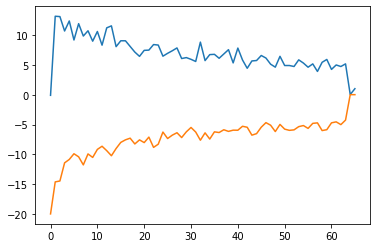

In [54]:
x_mx = np.max(D,axis=0)
x_mn = np.min(D,axis=0)
plt.plot(x_mx)
plt.plot(x_mn)
plt.show()

## Dataset and Dataloader

In [56]:
class LatentVectors(Dataset):
    def __init__(self, data,doPreprocess=False,w=1,simLen=200,mx=x_mx,mn=x_mn):
        self.data = data
        self.doPreprocess = doPreprocess
        self.simLen = simLen
        self.w = w
        self.mx = mx
        self.mn = mn
                 
    def __len__(self):
        return self.simLen*len(self.data)

    def preprocess(self,x):
        xnew = 2*((x-self.mn)/(self.mx-self.mn) - .5)
        return xnew

    def invPreprocess(self,xnew):
        x = ((xnew/2)+.5)*(self.mx-self.mn) + self.mn
        return x
    
    def __getitem__(self, idx):
        q,r = np.divmod(idx,self.simLen)
        X,p = self.data[q,:latentDim]
        r_idx = np.random.randint(0,self.simLen-self.w)
        x = np.hstack([X[r_idx:r_idx+1],p[r_idx:r_idx+1]])
        #print(x.shape)
        y = np.hstack([X[r_idx+1:r_idx+self.w+1],p[r_idx+1:r_idx+self.w+1]])
        #print(y.shape)
        if self.doPreprocess:
            x = self.preprocess(x)
            y = self.preprocess(y)
        return x, y

In [57]:
trainDataset = LatentVectors(train_data,doPreprocess=True,w=w,simLen=simLen,mx=x_mx,mn=x_mn)
testDataset = LatentVectors(test_data,doPreprocess=True,w=w,simLen=simLen,mx=x_mx,mn=x_mn)

In [58]:
X,y = trainDataset[4]
X.shape,y.shape

((1, 66), (10, 66))

In [ ]:
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=bz, shuffle=True, drop_last=True)
testDataLoader = DataLoader(dataset=testDataset, batch_size=bz)
len(trainDataset), len(trainDataLoader), len(testDataset), len(testDataLoader)

(19000, 296, 2000, 32)

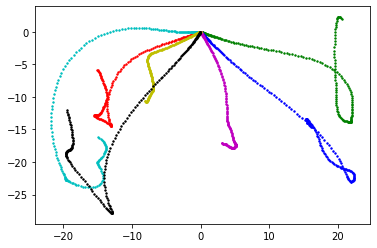

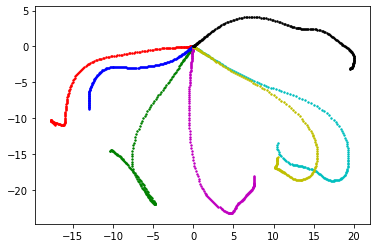

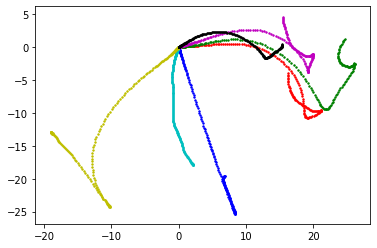

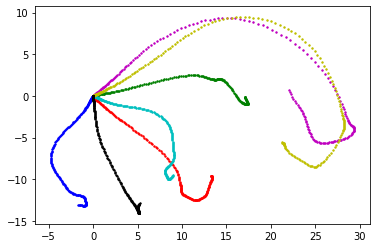

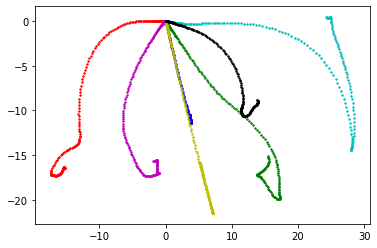

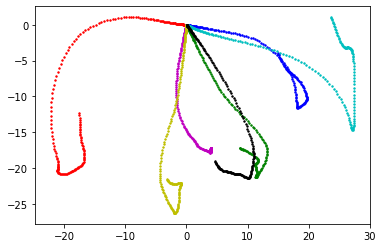

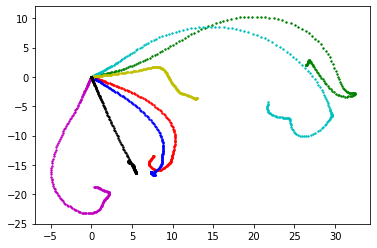

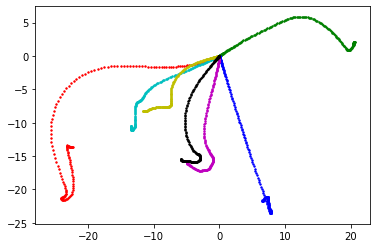

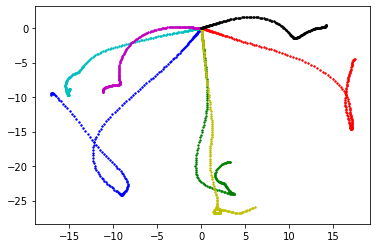

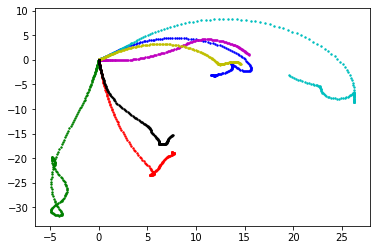

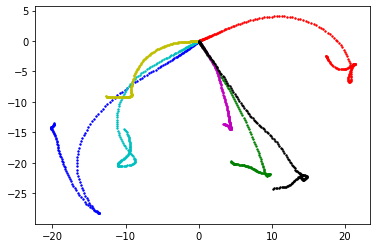

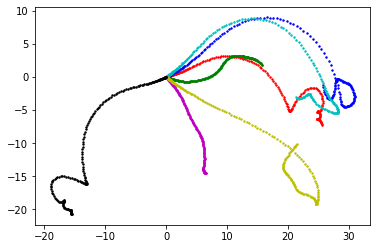

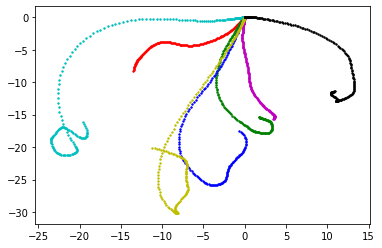

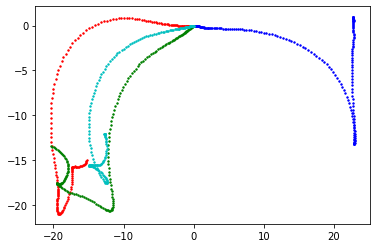

In [ ]:
# plot the first 2 coordinates of the first 3 simulations
# this makes me think that this is going to be a hard problem. 
Dplot = D.reshape(len(train_data),simLen,-1)
colors = ['r','g','b','c','m','y','k']
nc = len(colors)
for sim in range(0,len(train_data),nc):
    A = Dplot[sim:sim+nc]
    for idx, x in enumerate(A):
        plt.scatter(x[:,0],x[:,1],c=colors[idx],s=2)
    plt.show()

## Model

In [ ]:
class MLP(nn.Module):
    def __init__(self, X, hiddenLayerSizes = [1024], activation=nn.ELU()):
        super(MLP,self).__init__()
        
        self.activation = activation
        self.inputSize = X.shape[1:]
        self.modules = []
        self.modules.append(nn.Linear(np.prod(self.inputSize),hiddenLayerSizes[0]))
        self.modules.append(self.activation)
        for idx,sz in enumerate(hiddenLayerSizes[:-1]):
            self.modules.append(nn.Linear(hiddenLayerSizes[idx],hiddenLayerSizes[idx+1]))
            self.modules.append(self.activation)
                               
        self.modules.append(nn.Linear(hiddenLayerSizes[-1],np.prod(self.inputSize)))
        self.layers = nn.Sequential(*self.modules)
                                
        
    def forward(self,x):
        x = self.layers(x)
        return x

In [ ]:
X,y = next(iter(trainDataLoader))
X.shape, y.shape

(torch.Size([64, 1, 19]), torch.Size([64, 10, 19]))

In [ ]:
model = MLP(X, hiddenLayerSizes=hiddenLayers,activation=activation)
model

MLP(
  (activation): Tanh()
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=19, bias=True)
  )
)

In [ ]:
output = model(X)
output.shape

torch.Size([64, 1, 19])

In [ ]:
if len(gpu_ids.split(',')) > 1:
    model = nn.DataParallel(model)

In [ ]:
printNumModelParams(model)

6 layers require gradients (unfrozen) out of 6 layers
21,523 parameters require gradients (unfrozen) out of 21,523 parameters


## Loss Function

In [ ]:
L = nn.MSELoss()

In [ ]:
L(output,y[:,0:1,:])

tensor(0.1352, grad_fn=<MseLossBackward>)

In [ ]:
sum_loss = 0
out = X.clone()
for idx in range(w):
    out = model(out).clone()
    sum_loss += L(out,y[:,idx:idx+1,:])
sum_loss

tensor(1.3904, grad_fn=<AddBackward0>)

In [ ]:
combined_loss = L(output,y)
combined_loss.backward()

## Set LR

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



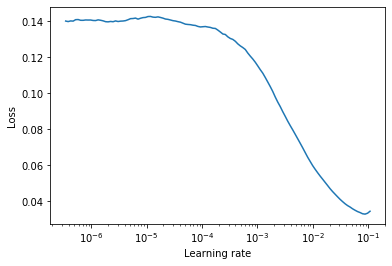

In [ ]:
if findLRs and (len(gpu_ids.split(','))==1): # doesn't work for multigpu???
    opt = create_opt(1e-7,model)
    find_lr(model,opt,L,device,trainDataLoader)


In [ ]:
max_lr = .005
opt = torch.optim.Adam(model.parameters(),lr=max_lr)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,patience=patience)

In [ ]:
versionName = versionName + '_lr{}'.format(str(max_lr))

In [ ]:
versionName

'LIN_SVD_MLP_manta_w10_latentDim16_hd128_128_bz64_epochs1000_lr0.005'

## Train

In [ ]:
def trainEpoch(myDataLoader, tensorboard_writer, model, opt, loss,
               metric, lr_scheduler, tensorboard_rate, device,
               tensorboard_recorder_step, total_steps):
    running_loss = 0.0
    running_rmse = 0.0
    total_loss = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Main Training ---
        combined_loss = 0.
        
        # gpu
        X,y = sampleBatch[0],sampleBatch[1]
        X = X.to(device)
        y = y.to(device)
        
        # zero the parameter gradients
        opt.zero_grad()

        y_hat = X.clone()
        predictions = []
        for w_idx in range(w):
            y_hat = model(y_hat).clone()
            y_hat[:,:,-p.shape[1]:] = y[:,w_idx:w_idx+1,-p.shape[1]:]
            predictions.append(y_hat)
            combined_loss += loss(y_hat,y[:,w_idx:w_idx+1,:])
        combined_loss.backward()
        opt.step()
        
        # loss
        batch_loss = combined_loss.item()
        running_loss += batch_loss
        total_loss += batch_loss

        # --- Metrics Recording ---

        # metrics
        predictions = torch.stack(predictions)
        r = metric(y_hat, y)
        running_rmse += r

        # record lr change
        total_steps += 1
        tensorboard_writer.add_scalar(tag="LR", scalar_value=opt.param_groups[0]['lr'], global_step=total_steps)

        # tensorboard writes
        if (i % tensorboard_rate == 0):
            tensorboard_recorder_step += 1
            avg_running_loss = running_loss/tensorboard_rate
            avg_running_rmse = running_rmse/tensorboard_rate
            tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)
            # reset running_loss for the next set of batches. (tensorboard_rate number of batches)
            running_loss = 0.0
            running_rmse = 0.0

    return total_loss/len(myDataLoader), tensorboard_recorder_step, total_steps


In [ ]:
def validEpoch(myDataLoader, tensorboard_writer, model, loss, metric,
               device, tensorboard_recorder_step):
    running_loss = 0.0
    running_rmse = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        combined_loss = 0.
        # --- Metrics Recording ---

        # gpu
        X,y = sampleBatch[0],sampleBatch[1]
        X = X.to(device)
        y = y.to(device)
        
        # forward, no gradient calculations
        with torch.no_grad():
            y_hat = X.clone()
            predictions = []
            for w_idx in range(w):
                y_hat = model(y_hat).clone()
                y_hat[:,:,-p.shape[1]:] = y[:,w_idx:w_idx+1,-p.shape[1]:]
                predictions.append(y_hat)
                combined_loss += loss(y_hat,y[:,w_idx:w_idx+1,:])

        running_loss += combined_loss.item()

        # metrics
        predictions = torch.stack(predictions)
        r = metric(y_hat, y)
        running_rmse += r

    avg_running_loss = running_loss/len(myDataLoader)
    avg_running_rmse = running_rmse/len(myDataLoader)
    tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
    tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)

    return avg_running_loss

In [ ]:
try:
    os.mkdir(cps)
except:
    print("checkpoints directory already exists :)")

checkpoints directory already exists :)


In [ ]:
# create a summary writer.
train_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'train'))
test_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'valid'))
tensorboard_recorder_step = 0
total_steps = 0

In [ ]:
model = model.to(device)
writeMessage('---------- Started Training ----------', versionName)
bestLoss = np.infty

for epoch in tqdm(range(1, epochs+1)):  # loop over the dataset multiple times
    
    writeMessage("--- Epoch {0}/{1} ---".format(epoch, epochs), versionName)
    
    model.train()
    trainLoss, tensorboard_recorder_step, total_steps = trainEpoch(trainDataLoader, 
                                                                   train_writer, model, opt, L,
                                                                   rmse, lr_scheduler, 
                                                                   tensorboard_rate, device,
                                                                   tensorboard_recorder_step, total_steps)
    
    writeMessage("trainLoss: {:.4e}".format(trainLoss),versionName)
    writeMessage("LR: {:.4e}".format(opt.param_groups[0]['lr']),versionName)
#     if trainLoss < bestLoss:
#         bestLoss = trainLoss
#         writeMessage("Better trainLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
#         torch.save(model.state_dict(), os.path.join(cps,versionName))
        
    model.eval()
    valLoss = validEpoch(testDataLoader, test_writer, model, L, rmse, device, tensorboard_recorder_step)
    writeMessage("valLoss: {:.4e}".format(valLoss),versionName)

    #checkpoint progress
    if valLoss < bestLoss:
        bestLoss = valLoss
        writeMessage("Better valLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
        torch.save(model.state_dict(), os.path.join(cps,versionName))

    lr_scheduler.step(trainLoss)
    #lr_scheduler.step(valLoss)
    
    if opt.param_groups[0]['lr'] < 5e-8:
        break
writeMessage('---------- Finished Training ----------', versionName)





  0%|          | 0/1000 [00:00<?, ?it/s]

---------- Started Training ----------
--- Epoch 1/1000 ---
trainLoss: 3.4074e-01
LR: 5.0000e-03






  0%|          | 1/1000 [00:05<1:38:49,  5.94s/it]

valLoss: 1.7740e-01
Better valLoss: 1.7740e-01, Saving models...
--- Epoch 2/1000 ---
trainLoss: 1.5189e-01
LR: 5.0000e-03






  0%|          | 2/1000 [00:11<1:36:32,  5.80s/it]

valLoss: 1.3657e-01
Better valLoss: 1.3657e-01, Saving models...
--- Epoch 3/1000 ---
trainLoss: 1.2331e-01
LR: 5.0000e-03






  0%|          | 3/1000 [00:17<1:36:44,  5.82s/it]

valLoss: 1.2298e-01
Better valLoss: 1.2298e-01, Saving models...
--- Epoch 4/1000 ---
trainLoss: 1.0686e-01
LR: 5.0000e-03






  0%|          | 4/1000 [00:22<1:33:53,  5.66s/it]

valLoss: 1.2326e-01
--- Epoch 5/1000 ---
trainLoss: 1.0069e-01
LR: 5.0000e-03






  0%|          | 5/1000 [00:28<1:35:05,  5.73s/it]

valLoss: 1.0934e-01
Better valLoss: 1.0934e-01, Saving models...
--- Epoch 6/1000 ---
trainLoss: 9.2788e-02
LR: 5.0000e-03






  1%|          | 6/1000 [00:34<1:37:30,  5.89s/it]

valLoss: 1.0865e-01
Better valLoss: 1.0865e-01, Saving models...
--- Epoch 7/1000 ---
trainLoss: 9.1937e-02
LR: 5.0000e-03






  1%|          | 7/1000 [00:40<1:36:53,  5.85s/it]

valLoss: 1.1598e-01
--- Epoch 8/1000 ---
trainLoss: 8.8360e-02
LR: 5.0000e-03






  1%|          | 8/1000 [00:46<1:36:49,  5.86s/it]

valLoss: 1.1915e-01
--- Epoch 9/1000 ---
trainLoss: 8.6183e-02
LR: 5.0000e-03






  1%|          | 9/1000 [00:52<1:35:39,  5.79s/it]

valLoss: 1.0834e-01
Better valLoss: 1.0834e-01, Saving models...
--- Epoch 10/1000 ---
trainLoss: 7.7916e-02
LR: 5.0000e-03






  1%|          | 10/1000 [00:57<1:34:22,  5.72s/it]

valLoss: 1.0022e-01
Better valLoss: 1.0022e-01, Saving models...
--- Epoch 11/1000 ---
trainLoss: 8.0480e-02
LR: 5.0000e-03






  1%|          | 11/1000 [01:04<1:39:26,  6.03s/it]

valLoss: 8.8773e-02
Better valLoss: 8.8773e-02, Saving models...
--- Epoch 12/1000 ---
trainLoss: 7.4792e-02
LR: 5.0000e-03






  1%|          | 12/1000 [01:09<1:36:22,  5.85s/it]

valLoss: 9.9288e-02
--- Epoch 13/1000 ---
trainLoss: 7.6943e-02
LR: 5.0000e-03






  1%|▏         | 13/1000 [01:15<1:37:38,  5.94s/it]

valLoss: 9.7666e-02
--- Epoch 14/1000 ---
trainLoss: 7.1842e-02
LR: 5.0000e-03






  1%|▏         | 14/1000 [01:21<1:33:45,  5.71s/it]

valLoss: 8.1691e-02
Better valLoss: 8.1691e-02, Saving models...
--- Epoch 15/1000 ---
trainLoss: 6.7062e-02
LR: 5.0000e-03






  2%|▏         | 15/1000 [01:26<1:33:23,  5.69s/it]

valLoss: 9.3076e-02
--- Epoch 16/1000 ---
trainLoss: 7.2486e-02
LR: 5.0000e-03






  2%|▏         | 16/1000 [01:31<1:30:46,  5.53s/it]

valLoss: 7.7722e-02
Better valLoss: 7.7722e-02, Saving models...
--- Epoch 17/1000 ---
trainLoss: 7.1969e-02
LR: 5.0000e-03






  2%|▏         | 17/1000 [01:37<1:29:55,  5.49s/it]

valLoss: 8.0328e-02
--- Epoch 18/1000 ---
trainLoss: 3.1749e-02
LR: 5.0000e-04






  2%|▏         | 18/1000 [01:42<1:30:42,  5.54s/it]

valLoss: 4.7122e-02
Better valLoss: 4.7122e-02, Saving models...
--- Epoch 19/1000 ---
trainLoss: 3.0173e-02
LR: 5.0000e-04






  2%|▏         | 19/1000 [01:49<1:36:43,  5.92s/it]

valLoss: 4.8280e-02
--- Epoch 20/1000 ---
trainLoss: 2.9710e-02
LR: 5.0000e-04






  2%|▏         | 20/1000 [01:55<1:34:01,  5.76s/it]

valLoss: 4.5573e-02
Better valLoss: 4.5573e-02, Saving models...
--- Epoch 21/1000 ---
trainLoss: 2.9397e-02
LR: 5.0000e-04






  2%|▏         | 21/1000 [02:00<1:32:36,  5.68s/it]

valLoss: 4.3381e-02
Better valLoss: 4.3381e-02, Saving models...
--- Epoch 22/1000 ---
trainLoss: 2.8807e-02
LR: 5.0000e-04






  2%|▏         | 22/1000 [02:06<1:32:33,  5.68s/it]

valLoss: 4.4762e-02
--- Epoch 23/1000 ---
trainLoss: 2.8743e-02
LR: 5.0000e-04






  2%|▏         | 23/1000 [02:11<1:32:03,  5.65s/it]

valLoss: 4.4338e-02
--- Epoch 24/1000 ---
trainLoss: 2.8077e-02
LR: 5.0000e-04






  2%|▏         | 24/1000 [02:17<1:34:17,  5.80s/it]

valLoss: 4.2935e-02
Better valLoss: 4.2935e-02, Saving models...
--- Epoch 25/1000 ---
trainLoss: 2.8216e-02
LR: 5.0000e-04






  2%|▎         | 25/1000 [02:24<1:36:00,  5.91s/it]

valLoss: 4.1693e-02
Better valLoss: 4.1693e-02, Saving models...
--- Epoch 26/1000 ---
trainLoss: 2.7993e-02
LR: 5.0000e-04






  3%|▎         | 26/1000 [02:29<1:35:16,  5.87s/it]

valLoss: 4.3179e-02
--- Epoch 27/1000 ---
trainLoss: 2.7564e-02
LR: 5.0000e-04






  3%|▎         | 27/1000 [02:34<1:30:58,  5.61s/it]

valLoss: 4.3551e-02
--- Epoch 28/1000 ---
trainLoss: 2.7303e-02
LR: 5.0000e-04






  3%|▎         | 28/1000 [02:40<1:29:44,  5.54s/it]

valLoss: 4.1005e-02
Better valLoss: 4.1005e-02, Saving models...
--- Epoch 29/1000 ---
trainLoss: 2.6772e-02
LR: 5.0000e-04






  3%|▎         | 29/1000 [02:45<1:27:50,  5.43s/it]

valLoss: 4.0775e-02
Better valLoss: 4.0775e-02, Saving models...
--- Epoch 30/1000 ---
trainLoss: 2.6675e-02
LR: 5.0000e-04






  3%|▎         | 30/1000 [02:50<1:25:51,  5.31s/it]

valLoss: 4.2221e-02
--- Epoch 31/1000 ---
trainLoss: 2.6546e-02
LR: 5.0000e-04






  3%|▎         | 31/1000 [02:55<1:25:42,  5.31s/it]

valLoss: 4.3684e-02
--- Epoch 32/1000 ---
trainLoss: 2.5897e-02
LR: 5.0000e-04






  3%|▎         | 32/1000 [03:01<1:25:48,  5.32s/it]

valLoss: 4.1772e-02
--- Epoch 33/1000 ---
trainLoss: 2.5873e-02
LR: 5.0000e-04






  3%|▎         | 33/1000 [03:06<1:25:11,  5.29s/it]

valLoss: 3.8558e-02
Better valLoss: 3.8558e-02, Saving models...
--- Epoch 34/1000 ---
trainLoss: 2.5762e-02
LR: 5.0000e-04






  3%|▎         | 34/1000 [03:11<1:23:43,  5.20s/it]

valLoss: 4.0418e-02
--- Epoch 35/1000 ---
trainLoss: 2.5507e-02
LR: 5.0000e-04






  4%|▎         | 35/1000 [03:17<1:26:37,  5.39s/it]

valLoss: 3.5823e-02
Better valLoss: 3.5823e-02, Saving models...
--- Epoch 36/1000 ---
trainLoss: 2.4876e-02
LR: 5.0000e-04






  4%|▎         | 36/1000 [03:22<1:24:51,  5.28s/it]

valLoss: 4.1324e-02
--- Epoch 37/1000 ---
trainLoss: 2.5256e-02
LR: 5.0000e-04






  4%|▎         | 37/1000 [03:28<1:27:53,  5.48s/it]

valLoss: 3.8960e-02
--- Epoch 38/1000 ---
trainLoss: 2.5246e-02
LR: 5.0000e-04






  4%|▍         | 38/1000 [03:34<1:30:44,  5.66s/it]

valLoss: 3.7963e-02
--- Epoch 39/1000 ---
trainLoss: 2.1509e-02
LR: 5.0000e-05






  4%|▍         | 39/1000 [03:40<1:33:33,  5.84s/it]

valLoss: 3.4367e-02
Better valLoss: 3.4367e-02, Saving models...
--- Epoch 40/1000 ---
trainLoss: 2.1431e-02
LR: 5.0000e-05






  4%|▍         | 40/1000 [03:46<1:32:56,  5.81s/it]

valLoss: 3.7172e-02
--- Epoch 41/1000 ---
trainLoss: 2.1668e-02
LR: 5.0000e-05






  4%|▍         | 41/1000 [03:51<1:30:23,  5.66s/it]

valLoss: 3.4858e-02
--- Epoch 42/1000 ---
trainLoss: 2.1356e-02
LR: 5.0000e-05






  4%|▍         | 42/1000 [03:56<1:28:23,  5.54s/it]

valLoss: 3.5421e-02
--- Epoch 43/1000 ---
trainLoss: 2.1454e-02
LR: 5.0000e-05






  4%|▍         | 43/1000 [04:02<1:28:37,  5.56s/it]

valLoss: 3.5318e-02
--- Epoch 44/1000 ---
trainLoss: 2.1692e-02
LR: 5.0000e-05






  4%|▍         | 44/1000 [04:09<1:33:42,  5.88s/it]

valLoss: 3.6176e-02
--- Epoch 45/1000 ---
trainLoss: 2.1303e-02
LR: 5.0000e-06






  4%|▍         | 45/1000 [04:14<1:31:41,  5.76s/it]

valLoss: 3.3815e-02
Better valLoss: 3.3815e-02, Saving models...
--- Epoch 46/1000 ---
trainLoss: 2.0924e-02
LR: 5.0000e-06






  5%|▍         | 46/1000 [04:20<1:30:17,  5.68s/it]

valLoss: 3.6453e-02
--- Epoch 47/1000 ---
trainLoss: 2.0834e-02
LR: 5.0000e-06






  5%|▍         | 47/1000 [04:26<1:31:58,  5.79s/it]

valLoss: 3.5246e-02
--- Epoch 48/1000 ---
trainLoss: 2.0967e-02
LR: 5.0000e-06






  5%|▍         | 48/1000 [04:31<1:30:18,  5.69s/it]

valLoss: 3.5162e-02
--- Epoch 49/1000 ---
trainLoss: 2.0911e-02
LR: 5.0000e-06






  5%|▍         | 49/1000 [04:36<1:29:02,  5.62s/it]

valLoss: 3.4974e-02
--- Epoch 50/1000 ---
trainLoss: 2.0892e-02
LR: 5.0000e-07






  5%|▌         | 50/1000 [04:43<1:32:05,  5.82s/it]

valLoss: 3.4554e-02
--- Epoch 51/1000 ---
trainLoss: 2.1019e-02
LR: 5.0000e-07






  5%|▌         | 51/1000 [04:48<1:29:17,  5.65s/it]

valLoss: 3.4256e-02
--- Epoch 52/1000 ---
trainLoss: 2.0670e-02
LR: 5.0000e-08






  5%|▌         | 52/1000 [04:53<1:27:38,  5.55s/it]

valLoss: 3.4839e-02
--- Epoch 53/1000 ---
trainLoss: 2.0753e-02
LR: 5.0000e-08






  5%|▌         | 53/1000 [04:59<1:26:14,  5.46s/it]

valLoss: 3.6328e-02
--- Epoch 54/1000 ---
trainLoss: 2.0696e-02
LR: 5.0000e-08
valLoss: 3.5448e-02
---------- Finished Training ----------


## Test on the last trained model on Full simLen

In [ ]:
model.eval()

MLP(
  (activation): Tanh()
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=19, bias=True)
  )
)

In [ ]:
def invPreprocess(xnew):
    x = ((xnew/2)+.5)*(x_mx-x_mn) + x_mn
    return x


def test_model(model,test_ind,doPlot=False):
    # last model
    idx = test_ind # choose one of the test samples
    testDataset = LatentVectors(test_data[idx:idx+1],doPreprocess=True,w=simLen-1,mx=x_mx,mn=x_mn)
    testDataLoader = DataLoader(dataset=testDataset, batch_size=1)
    X,y = next(iter(testDataLoader))
    X.shape, y.shape

    xhat = X.to(device).clone()
    out = []
    for idx in range(y.shape[1]):
        xhat = model(xhat).clone()
        xhat[:,:,-p.shape[1]:] = y[:,idx:idx+1,-p.shape[1]:]
        out.append(xhat)
    out = torch.stack(out).squeeze()

    yy = y.squeeze().to(device)
    err = []
    for i in range(out.shape[0]):
        e = invPreprocess(yy[i].detach().cpu().numpy()) - invPreprocess(out[i].detach().cpu().numpy())
        err.append(np.linalg.norm(e))

    if doPlot:
        plt.plot(err)
        plt.title('Test Sample'.format(test_ind))
        
    return err

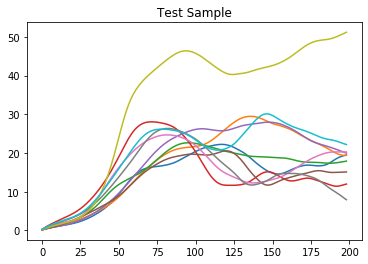

In [ ]:
Err = []
for idx in range(len(test_data)):  
    e = test_model(model,idx,True)
    Err.append(e)

In [ ]:
np.mean(Err)

17.54997

## Test on the best validation model on Full simLen

In [ ]:
# best val loss model
model.load_state_dict(torch.load(os.path.join(cps,versionName)))
model = model.to(device)

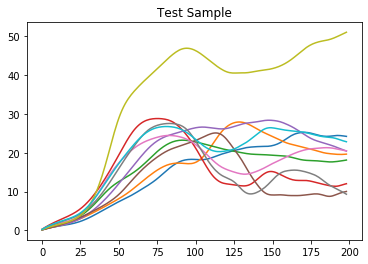

In [ ]:
Err = []
for idx in range(len(test_data)):  
    e = test_model(model,idx,True)
    Err.append(e)

In [ ]:
np.mean(Err)

34.40713

## Relative Error

In [ ]:
def test_model_rel_err(model,test_ind,doPlot=False):
    # last model
    idx = test_ind # choose one of the test samples
    testDataset = LatentVectors(test_data[idx:idx+1],doPreprocess=True,w=simLen-1,mx=x_mx,mn=x_mn)
    testDataLoader = DataLoader(dataset=testDataset, batch_size=1)
    X,y = next(iter(testDataLoader))
    X.shape, y.shape

    xhat = X.to(device).clone()
    out = []
    for idx in range(y.shape[1]):
        xhat = model(xhat).clone()
        xhat[:,:,-p.shape[1]:] = y[:,idx:idx+1,-p.shape[1]:]
        out.append(xhat)
    out = torch.stack(out).squeeze()

    yy = y.squeeze().to(device)
    err = []
    for i in range(out.shape[0]):
        label = invPreprocess(yy[i].detach().cpu().numpy())
        e =  label - invPreprocess(out[i].detach().cpu().numpy())
        err.append(np.linalg.norm(e)/np.linalg.norm(label))

    if doPlot:
        plt.plot(err)
        plt.title('Test Samples Relative Errors'.format(test_ind))
        
    return err

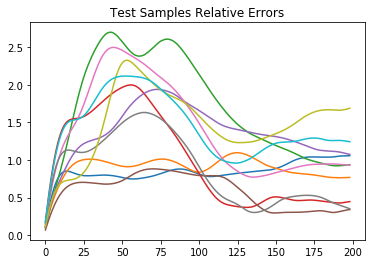

In [ ]:
Err = []
for idx in range(len(test_data)):  
    e = test_model_rel_err(model,idx,True)
    Err.append(e)